In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [2]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        build_differet_shapes_stimulus_generator(rng=rng, **kwargs), 
        
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        build_random_color_stimulus_generator(rng=rng, **kwargs)
    )
    
    return zip(generators, names)

In [3]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (50, 80),
    (True, True): (40, 80),  
}

# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



# Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9D46E50}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9D46E50}


## color bar | above_below | one ref

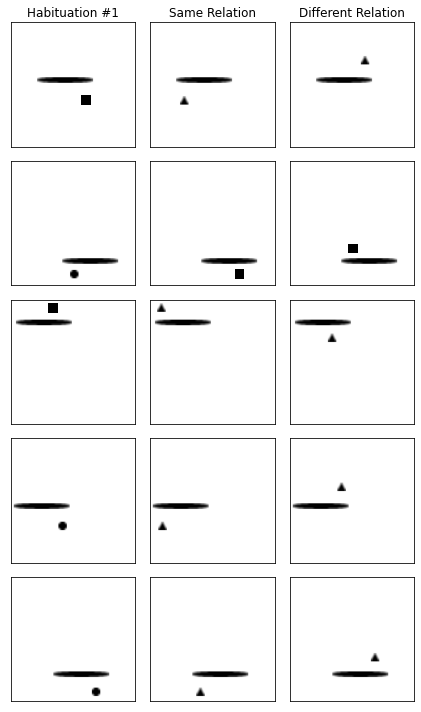

----

## split text | above_below | one ref

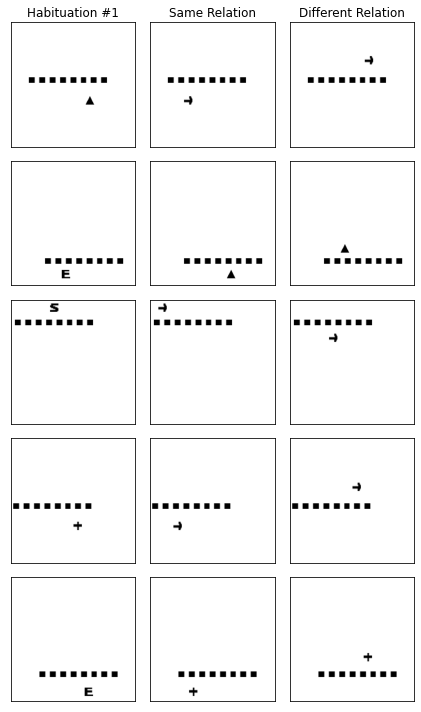

----

## random colors | above_below | one ref

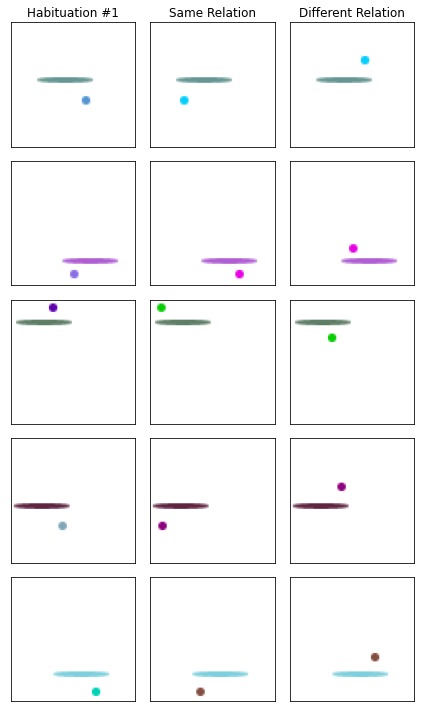

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFEA90}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFEA90}


## color bar | above_below | two refs | non-adjacent refs

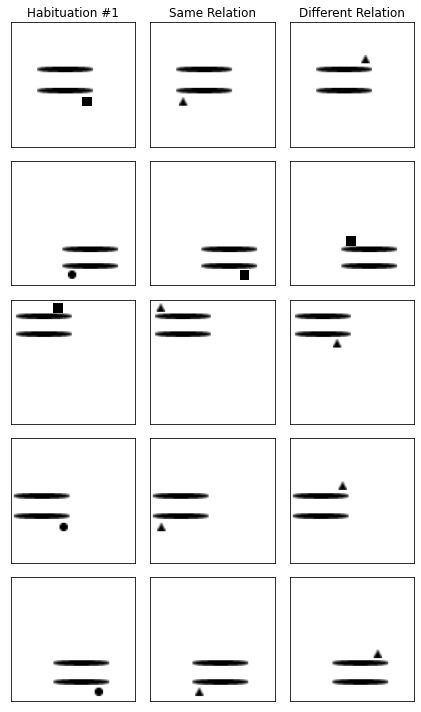

----

## split text | above_below | two refs | non-adjacent refs

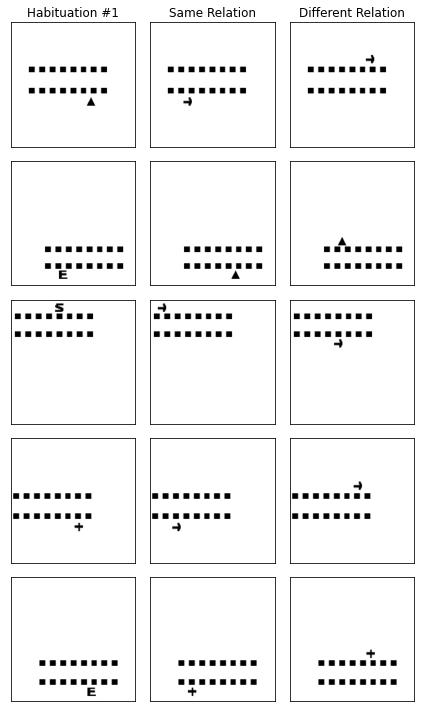

----

## random colors | above_below | two refs | non-adjacent refs

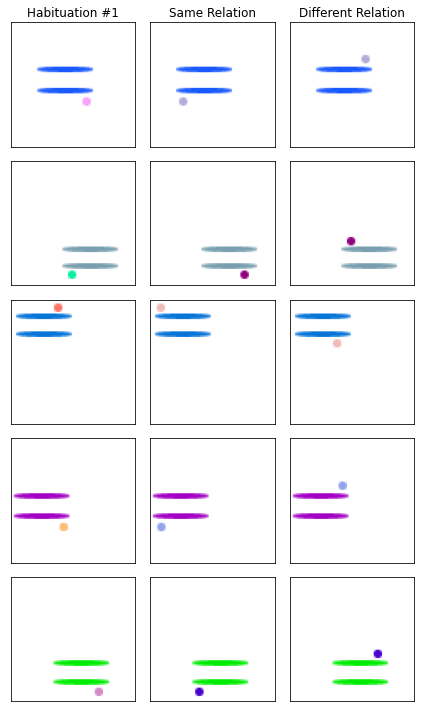

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFE8B0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFE8B0}


## color bar | above_below | two refs | adjacent refs

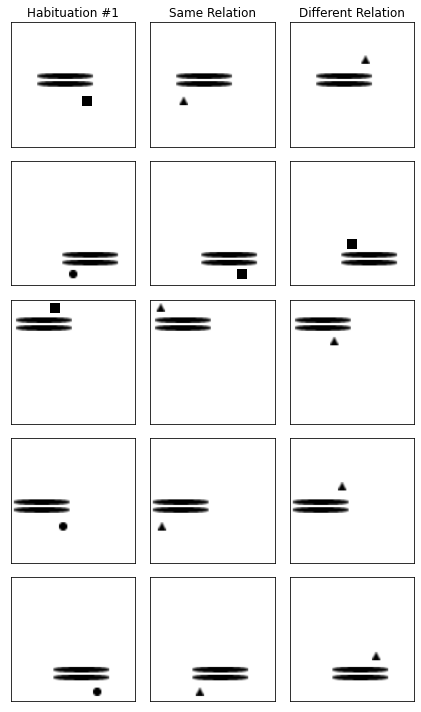

----

## split text | above_below | two refs | adjacent refs

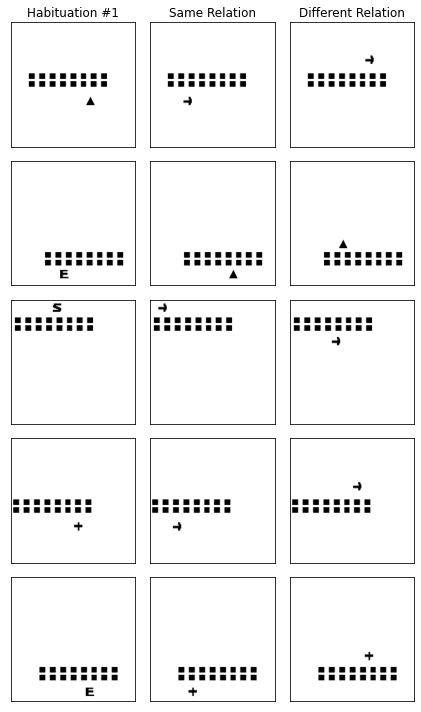

----

## random colors | above_below | two refs | adjacent refs

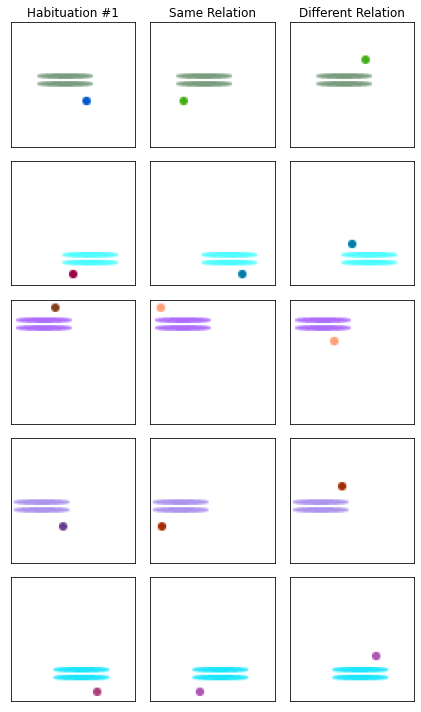

----

In [4]:
relation = ABOVE_BELOW_RELATION
N_examples = 5

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names():
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, **BASELINE_TRIPLET_KWARGS)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


# Between/Outside

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFEC70}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFEC70}


## color bar | between

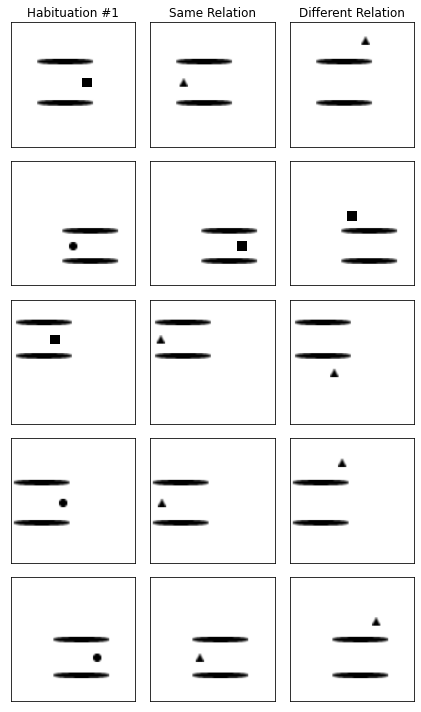

----

## split text | between

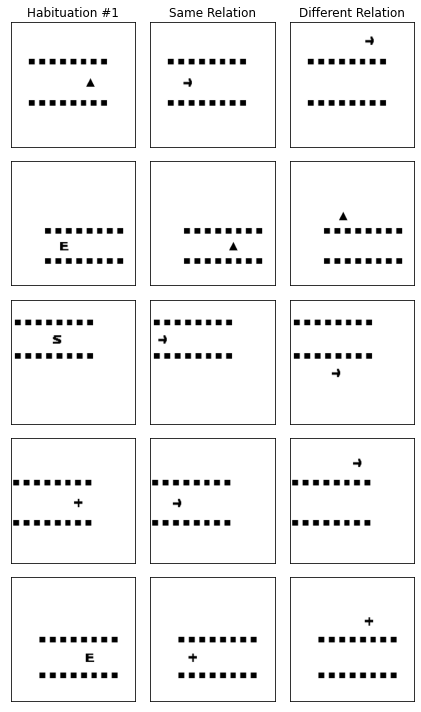

----

## random colors | between

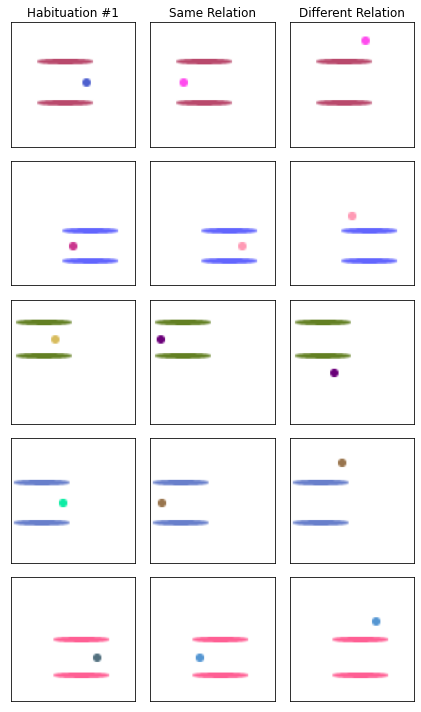

----

In [5]:
relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in create_stimulus_generators_and_names():
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


# Diagonal Above/Below

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79B89D0130}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79B89D0130}


## color bar | above_below | 30 degrees

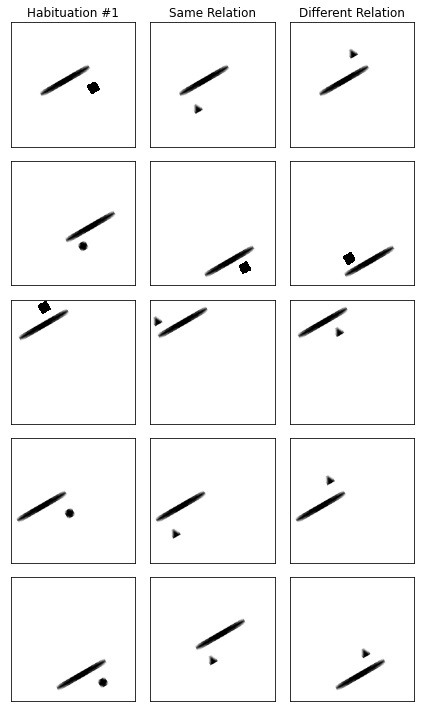

----

## split text | above_below | 30 degrees

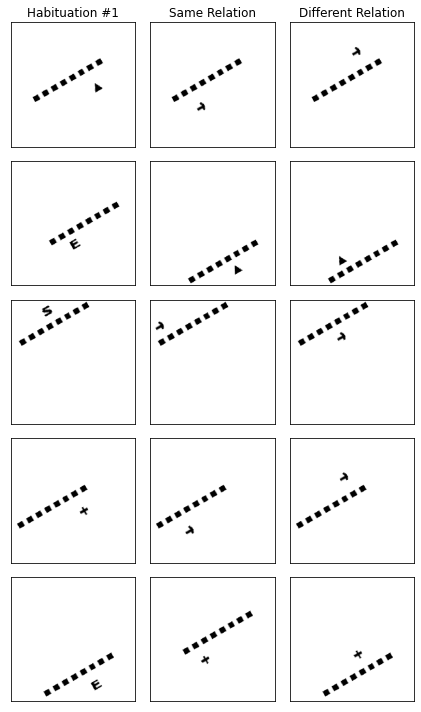

----

## random colors | above_below | 30 degrees

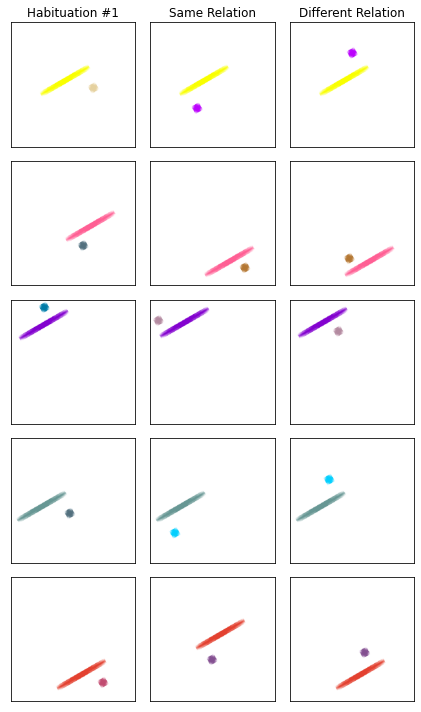

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79B89D09A0}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79B89D09A0}


## color bar | above_below | 45 degrees

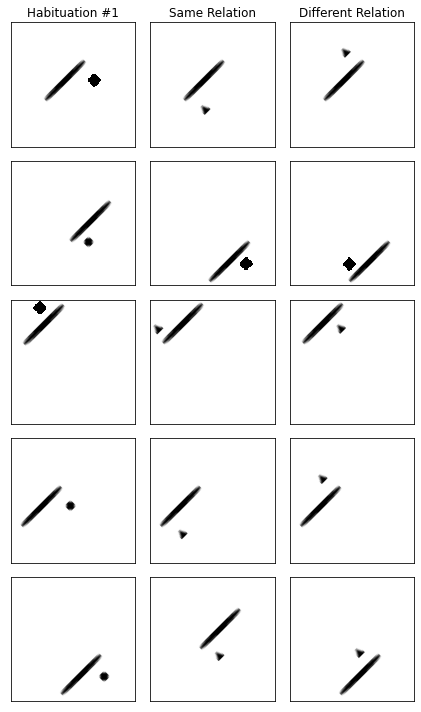

----

## split text | above_below | 45 degrees

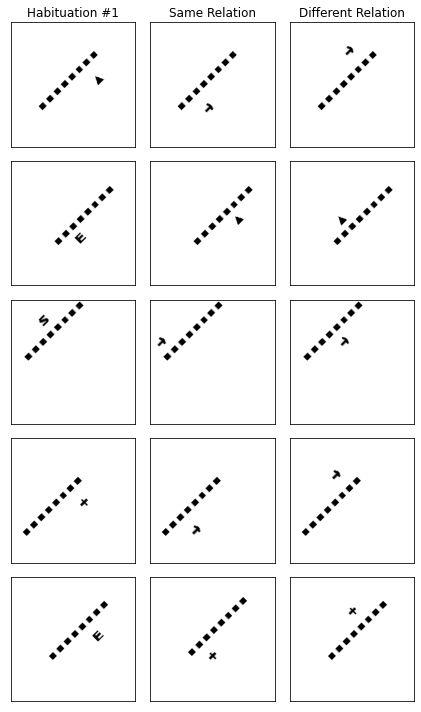

----

## random colors | above_below | 45 degrees

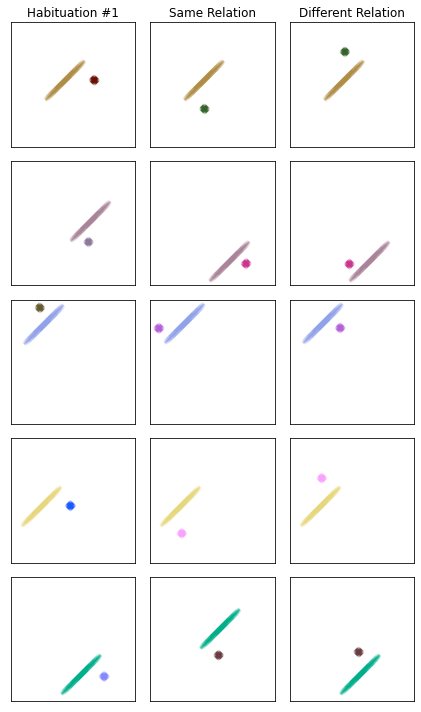

----

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFE400}
Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFE400}


## color bar | above_below | 60 degrees

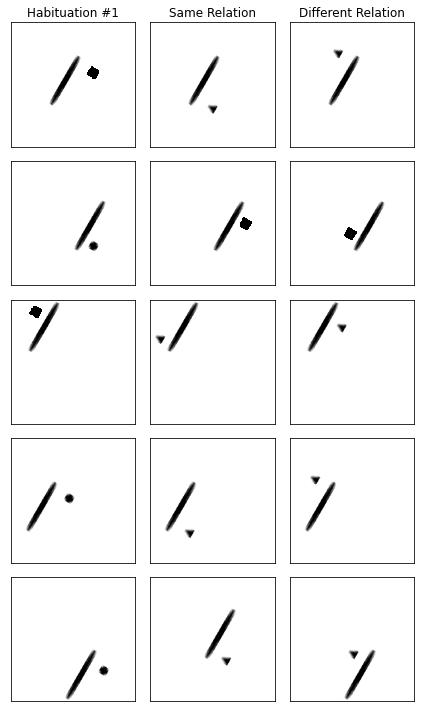

----

## split text | above_below | 60 degrees

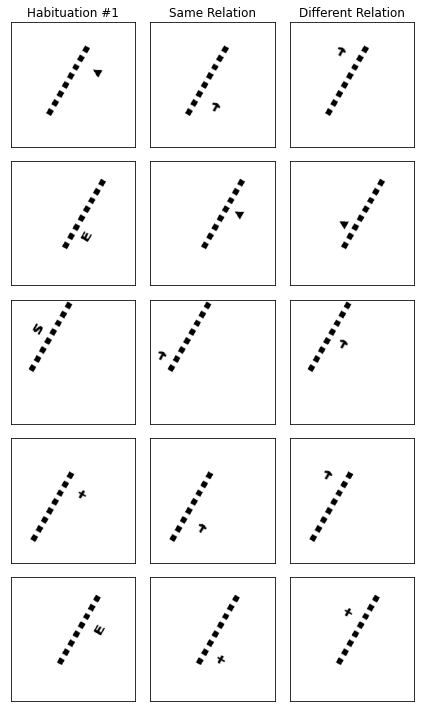

----

## random colors | above_below | 60 degrees

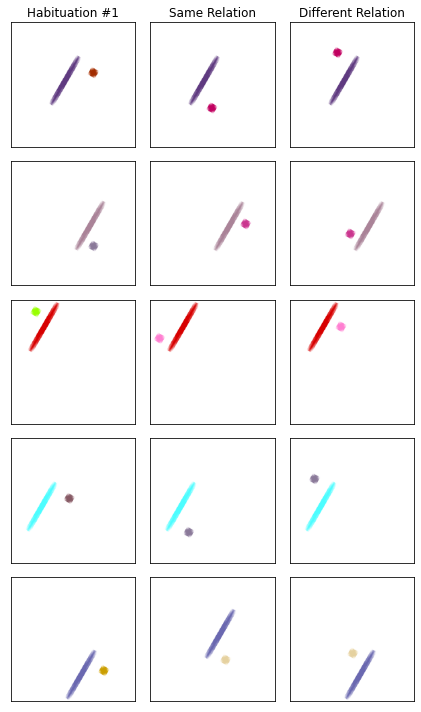

----

In [6]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 5

display(Markdown('# Diagonal Above/Below'))

# distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60):
    for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False, **BASELINE_TRIPLET_KWARGS)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation} | {rotate_angle} degrees'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


Note for the above: we could obviously run all of the different variations of above/below (two reference objects, what sort of gap betwen them, etc.) on the diagonal case as well, if we wanted to.

Similarly, we could run between/outside diagonally, too.

Not plotted but also exist are the left/right and vertical between stimuli, which are just the non-diagonal stimuli transposed. 

Let me know if you want me to plot any of the above.

### TODO:
One significant things is still missing here:
1. I haven't finished implementing the condition where we create more than one habituation stimulus.

# Multiple Habituation Stimuli

Ignoring kwargs: {'rng': Generator(PCG64) at 0x7F79F9EFEE50}


## 4 habituation stimuli

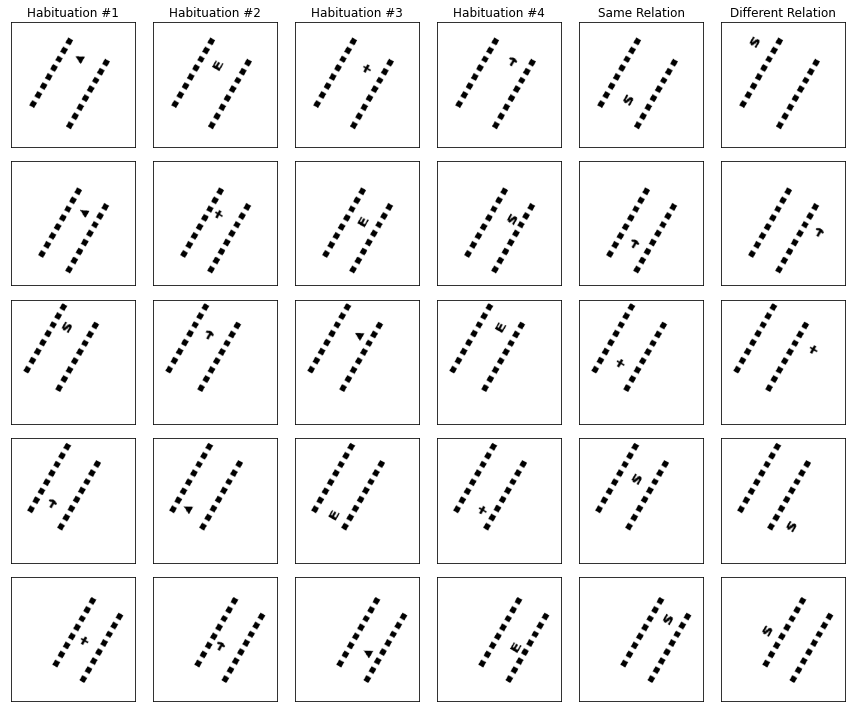

----

In [7]:
relation = BETWEEN_RELATION
distance_endpoints = (40, 80)
N_examples = 5
n_habituation_stimuli = 4

display(Markdown('# Multiple Habituation Stimuli'))

rng = np.random.default_rng(n_habituation_stimuli)
stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=60)
# stimulus_generator = build_random_color_stimulus_generator(rng=rng)

triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
    relation=relation, two_reference_objects=True, 
    adjacent_reference_objects=False, n_habituation_stimuli=n_habituation_stimuli,
    **BASELINE_TRIPLET_KWARGS)

# adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
# title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
title = f'{n_habituation_stimuli} habituation stimuli'
display(Markdown(f'## {title}'))
triplets = triplet_generator(N_examples, normalize=False)
plot_triplets(triplets)
display(Markdown('----'))
